<a href="https://colab.research.google.com/github/3lueLightning/tutorials/blob/main/rag_development_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This notebook aims to demonstrate the development process when starting to create RAG based LLM applications. The code is not optimized and goes through various development steps one at a time, including validations and handling of errors. Yes, you heard right—errors (but they are all caught in try-except clauses to prevent the code from breaking).

In [1]:
! pip install -q langchain langchain_community tiktoken langchain_openai \
langchain_text_splitters docarray langsmith langchainhub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

# 1. Loading the data
LLMs excel at answering questions and powering chatbots, but their knowledge is limited to their training data. RAG is crucial for accessing new information, such as private data, by providing relevant data through prompts. This often involves retrieving information from a database (DB) and loading it initially. In this example, we'll extract Empire magazine's top 100 movies of all time and feed it into a database. Let me know in the comments if you agree with the list! 😉

In [ ]:
import os
from langchain_community.document_loaders import WebBaseLoader

MOVIES_URL = "https://www.empireonline.com/movies/features/best-movies-2/"

# Note regarding ethical crawling: according to their robots.txt, all user
# agents are allowed, and we are only accessing one page in the entire
# notebook. Since all user agents are permitted, there's no need to fake one,
# so you can disregard the warning below.

## 1.1 Test connection

Before we write the actual code to fetch web data for our LLM, we need to ensure that the page is accessible. Crawling can be complex, so it's prudent to verify our access with a simple HTTP request. WebBaseLoader does a combination of `requests.get` and `bs4.BeautifulSoup`, more info [here](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)

In [ ]:
# In the tutorial I added some extra try-excepts to avoid issues. In real life
# I'd test this line and if it succeeded I'd remove this entire cell.
try:
  full_page = WebBaseLoader(MOVIES_URL).load()
  print(full_page[0].page_content[:50])
except:
  # I know it's not super clean to make an catch all exception
  # but I rather be safe then sorry :P
  full_page = []
  print("The page didn't load, but no worries we have a backup ;)")

The 100 Best Movies Of All Time | Movies | %%chann


## 1.2 Get data

We don't need the entire page's data but only a small fraction, so `SoupStainer` comes to the rescue. It allows us to extract information from HTML without loading everything into memory first and then filtering the results using `find_all`. This makes it the most efficient option. More information can be found [here](https://medium.com/codex/using-beautiful-soups-soupstrainer-to-save-time-and-memory-when-web-scraping-ea1dbd2e886f). So this time, we'll run the WebBasedLoader with the `bs_kwargs` argument to configure the strainer inside to extract only the information we need.

In [ ]:
from bs4 import SoupStrainer


def is_target_element(elem: str, attrs: dict) -> bool:
    """
    Returns true if the HTML element is what we want to extract.
    """
    # get the movie description
    div_class = "listicleItem_listicle-item__content__Lxn1Y"
    div_mask = (elem == "div" and attrs.get("class") == div_class)
    # get the movie title
    h3_class = "listicleItem_listicle-item__title__BfenH"
    h3_mask = (elem == "h3" and attrs.get("class") == h3_class)
    return div_mask or h3_mask

strainer = SoupStrainer(is_target_element)


movie_scraper = WebBaseLoader(
    MOVIES_URL,
    bs_kwargs = {
        "parse_only": strainer
    }
)

# this try except is to prevent the code from crashing in case something
# happens to the page
try:
  # only here is the page actually loaded
  movie_reviews_raw = movie_scraper.load()
except:
  movie_reviews_raw = []

The  cell below is not really important, it simply downloads the page data from a backup system on AWS if the orginal page is not accessible for some reason. It only exists to the purpose of this tutorial and can be ignore if you're building your own LLM app

In [ ]:
# no need to read this cell it is just a backup system in case the scraping fails
if (
    not movie_reviews_raw
    or movie_reviews_raw[0].page_content[:25] != "100 Reservoir Dogs\nMaking"
):
  import pickle
  import urllib
  BACKUP_MOVIES_PKL_URL = "https://tutorials-public.s3.eu-west-1.amazonaws.com/movie_reviews_raw.pkl"
  with urllib.request.urlopen(BACKUP_MOVIES_PKL_URL) as response:
      movie_reviews_raw = pickle.load(response)
  print("loaded list of top 10 best movies from backup system")
else:
  print("successfully scrapped list of top 10 best movies")

successfully scrapped list of top 10 best movies


# 2. Process data

All the movie reviews come as a single document, but we want to split them and remove the links to the full movie reviews at the end of each block

In [ ]:
import re
from langchain.docstore.document import Document


def split_movies(page: Document) -> list[Document]:
  """
  Split page into a list of movie reviews
  """
  page_parts = page.page_content.strip().split("\n")
  names_n_reviews = [p for p in page_parts if not p.startswith("Read")]
  pattern = r'^\d*\)? '
  movie_names = [re.sub(pattern, "", name) for name in names_n_reviews[::2]]
  movie_reviews = [
      f"{name}: {description}"
      for name, description in zip(movie_names, names_n_reviews[1::2])
  ]
  movie_docs = [
      Document(review, metadata={**page.metadata, "rank": i, "name": name})
      for review, i, name in zip(movie_reviews, range(100, 0, -1), movie_names)
  ]
  return movie_docs


movie_reviews = split_movies(movie_reviews_raw[0])
print(f"extracted {len(movie_reviews)}")
movie_reviews[0]

extracted 100


Document(metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 100, 'name': 'Reservoir Dogs'}, page_content="Reservoir Dogs: Making his uber cool and supremely confident directorial debut, Quentin Tarantino hit audiences with a terrific twist on the heist-gone-wrong thriller. For the most part a single location chamber piece, Reservoir Dogs delights in ricocheting the zing and fizz of its dialogue around its gloriously —and indeed gore-iously) — intense setting, with the majority of the movie's action centring around one long and incredibly bloody death scene. Packing killer lines, killer needledrops, and killer, er, killers too, not only is this a rollicking ride in its own right, but it also set the blueprint for everything we've come to expect from a Tarantino joint. Oh, and by the way: Nice Guy Eddie was shot by Mr. White. Who fired twice. Case closed.")

`OPENAI_API_KEY`

## 2.1 Data Analysis
(this mini section isn't present on the Medium article)  
Let's check if there are any issues with the data and understand how much we will be charged by OpenAI. Keep in mind that we are charged based on tokens sent and received to and from their API. OpenAI's method of tokenizing is via "tiktoken."


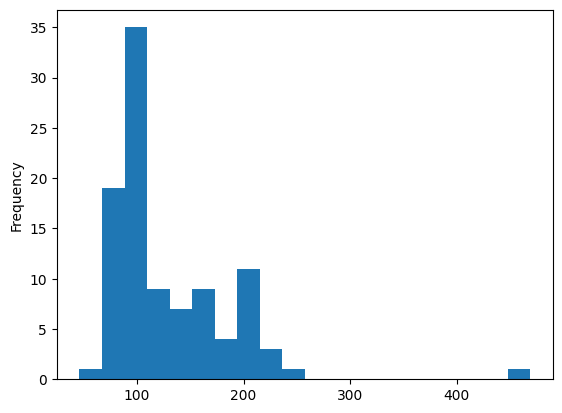

In [ ]:
import tiktoken
import pandas as pd


def count_tokens(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

token_counts = pd.Series(movie_reviews).apply(
    lambda doc: count_tokens(doc.page_content, "cl100k_base")
)
token_counts.plot.hist(bins=20);

We noticed that one movie has substantially more tokens than the others, so we need to ensure there are no issues. However, as you can see, the description for "The Lord of the Rings" is simply very lengthy, which, as any Tolkien fan would know, is only fair.

In [ ]:
import numpy as np

movie_reviews[np.argmax(token_counts)].page_content

"The Lord Of The Rings: The Fellowship Of The Ring: A wizard is never late. Nor is he early. He arrives precisely when he... well, you know the rest. It might have taken 20 years for Peter Jackson's plucky fantasy to clamber, Mount-Doom-style, to the very pinnacle of our greatest-movies pantheon. But here it is, brighter and more resplendent than ever.The Fellowship Of The Ring contains so much movie. Even at the halfway point, as the characters take a breather to bicker in Rivendell, you already feel sated, like you've experienced more thrills, more suspense, more jollity and ethereal beauty than a regular film could possibly muster up. But Jackson is only getting started. Onwards his adventure hustles, to the bravura dungeoneering of Khazad-dum, to the sinisterly serene glades of Lothlorien, to the final requiem for flawed Boromir amidst autumnal leaves. As Fellowship thrums to its conclusion, finally applying the brakes with a last swell of Howard Shore's heavenly score, you're left

# 3. Set up database
## 3.1 RAG in a nutshell - part 1
Our next goal is to make various movie reviews accessible to our Large Language Model. The steps to achieve this are:
1. **Embedding Selection**: Convert text into its numerical representation (embedding) to capture its essence. Similar texts will have similar vectors (e.g., the embedding for "man" is similar to that for "woman" and very different from "meteor").
2. **Chunking**: Split the original text (movie reviews) into smaller pieces before inserting them into the database.
3. **Database Creation and Insertion**: Insert the chunks and their corresponding embeddings into a database.
4. **Data Retrieval**: After embedding the user query, find the closest vector to the query vector (using cosine similarity). Return the chunks corresponding to the k closest matches (you define k).

Then pass the retrieved information to the LLM (more details in part 2 of this article).

## 3.2 Embedding selection
To convert text into embeddings we use Open API's models, more info [here](https://platform.openai.com/docs/guides/embeddings).

Below you can set your OPENAI_API_KEY, this is safe way of handling it. If you don't have one you can create a legacy API KEY or a project API KEY where you can have more fine-grained access control, check [here](https://medium.com/@alozie_igbokwe/ai-api-key-essentials-part-1-how-to-set-up-your-openai-api-key-a-quick-beginner-guide-51c3a098b077). With the basic [free tier](https://platform.openai.com/docs/guides/rate-limits/usage-tiers?context=tier-free) you can use all the code in this notebook without concern.

In [ ]:
import getpass
OPENAI_API_KEY = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

··········


In [ ]:
from langchain_openai import OpenAIEmbeddings

# OpenAI has multiple models, transforms the text in longer vectors (here
# length of 3072) and carries out more information about the original text.
# It is also more expensive and requires more space to store.
EMBEDDING_MODEL_NAME = "text-embedding-3-large"

embeder = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# testing embeding
test_embedding = embeder.embed_query("What is 'Hello World'?")
print(test_embedding[:5])
print(f"the model {EMBEDDING_MODEL_NAME} generates embeddings"
      f" of length: {len(test_embedding)}")

[-0.015853295102715492, -0.056399740278720856, -0.014421384781599045, 0.019666852429509163, -0.017855048179626465]
the model text-embedding-3-large generates embeddings of length: 3072


## 3.3 Chunking
By default `RecursiveCharacterTextSplitter` uses the following separators `["\n\n", "\n", " ", ""]`. This means that it:
1. It first tries to create chunks with as many paragraphs as possible without exceeding the chunk_sizelimit (using "\n\n" as a separator).
2. If a paragraph exceeds the limit, it then splits based on lines ("\n").
3. If a line exceeds the limit, it splits based on words (" ").
4. If a word exceeds the limit, it splits by individual characters.

This recursive process stops once a condition is met, removing the chunked text and repeating for the rest of the string.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
# docarray was imported earlier to avoid an error when using from_documents()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    length_function=len,
)

text_splitter.split_text(movie_reviews[5].page_content)

["Donnie Darko: A high school drama with a time traveling, tangential universe threading, sinister rabbit featuring twist, Richard Kelly's deliberately labyrinthine opus was always destined for cult classic status. A certifiable flop upon its theatrical release, Kelly's film was one of the early beneficiaries of physical media's move to DVD, with the movie gaining a fandom in film obsessives who could pause, play, and skip back and forth through it at will. Any attempt to synopsise the movie is a fool's errand, but there's more than a hint of\xa0It's A Wonderful Life in the way we see Donnie (Jake Gyllenhaal, in a star-making turn) experiencing how the world would be worse off if he survives the jet engine that mysteriously crashes through his bedroom. That the film, with all its heavy themes and brooding atmosphere, manages to eventually land on a note of overwhelming optimism is a testament to Kelly's mercurial moviemaking. A mad world (mad world) Donnie Darko's may be, but it's also

## 3.4 Database: creation and insertion
The index helps us manage our vector database, so named because data is retrieved by comparing the vector (embedding) of the query to the vectors (embeddings) of the chunks in the database. While there are many vector databases available, we'll keep it simple for this example. Given the small dataset, we can store all the data in memory using `DocArrayInMemorySearch`.


In [ ]:
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch


# from_documents is the method that inserts or list of documents in the DB
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeder,
    text_splitter=text_splitter,
).from_documents(movie_reviews)

/usr/local/lib/python3.10/dist-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


## 3.5 Data Retrieval
Test that the index is working. As you can see the embeddings and index worked properly as we have succesfully extracted 3 adventure movies.

In [ ]:
# this cell is purely to test everything worked as planned

retriever = index.vectorstore.as_retriever()
# find the closest matches to the query
relevant_movies = retriever.vectorstore.similarity_search(
    "Can you recommend me an adventure movie?",
    k=3 # by default k=4
)
for doc in relevant_movies:
  print(doc.page_content)

Indiana Jones And The Last Crusade: You voted... wisely. There may only be 12 years' difference between Harrison Ford and Sean Connery, but it's hard to imagine two better actors to play a bickering father and son, off on a globetrotting, Nazi-bashing, mythical mystery tour. After all, you've got Spielberg/Lucas' own version of James Bond... And the original Bond himself.
Raiders Of The Lost Ark: In '81, it must have sounded like the ultimate pitch: the creator of Star Wars teams up with the director of Jaws to make a rip-roaring, Bond-style adventure starring the guy who played Han Solo, in which the bad guys are the evillest ever (the Nazis) and the MacGuffin is a big, gold box which unleashes the power of God. It still sounds like the ultimate pitch.
Lawrence Of Arabia: If you only ever see one David Lean movie... well, don't. Watch as many as you can. But if you really insist on only seeing one David Lean movie, then make sure it's Lawrence Of Arabia, the movie that put both the "s

# 4. Create RAG chain
## 4.1. RAG in a Nutshell - Part 2
Having successfully set up an in-memory vector database (managed by an index) populated with movie review data, our next steps are to:
1. Set up the LLM: This involves selecting a model and establishing an API connection.
2. Create the prompt template: the code sort of "meta prompt" that wraps the user's query.
3. Create the RAG chain: This chain automatically retrieves data from the database based on the user query, inserts the retrieved content into the "meta-prompt" sent to the LLM, and includes the actual user query/prompt.
4. Obtain the final answer.

## 4.2. Setting Up the LLM
We will use OpenAI's GPT-3.5 Turbo. This model is part of the free tier with a limit of 3 RPM (requests per minute) at the time of writing. For more advanced models like GPT-4, you'll need to spend at least $5 to move to Tier 1 (the lowest of five tiers).

There are many other model providers, such as Anthropic, Mistral AI, and others, constantly vying for supremacy. Additionally, there are open-source models like Llama3 that can be hosted locally on your laptop using tools like Ollama, or via the cloud with Amazon BedRock and others. I chose OpenAI for this first article because of its simplicity, but in future articles, I will explore other options.

This brings me to one of the reasons to use the LangChain framework rather than OpenAI directly: it prevents vendor and model lock-in. LangChain allows you to switch models and vendors with minimal code changes. While some adjustments, such as optimizing your prompt for the model you are using, are always needed, LangChain substantially reduces the effort involved.

In [ ]:
# this will use the API key set up above
# note: we are note using the OpenAI API directly but using it via langchain
from langchain_openai import ChatOpenAI


LLM_MODEL_NAME = "gpt-3.5-turbo"
llm = ChatOpenAI(
    model=LLM_MODEL_NAME,
    # higher temperature means more original answers
    temperature=1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# testing that the LLM works, you will observe that the final answer provides
# a count of the tokens used in the prompt and in the reply (completion_tokens)
# Which are what you will be charged for outside of the free tier
llm.invoke("Hey how are you GPTie?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you with any questions or needs you have. How can I assist you today?", response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 15, 'total_tokens': 55}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-3983ca98-c1dd-4035-8e7c-dbf897e1355e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 40, 'total_tokens': 55})

## 4.3 Create the prompt template
The main reason to create a prompt template rather then an f-string it integrate it with the rest of LangChain and to more clearly estrablish the various roles in the mechanism (eg. "system", "human", etc.). Here we ask the LLM to provide movie recommendations as if it was movie wizard.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# define how the LLM should respond in general
system_message = """
When asked a question reply as if you were the wizard of movies with the \
knowledge about movies. Try to be funny were possible but base you answers in \
the information provided in the context section.\
"""
# wraps the user query represented by {question} and provides documents from
# the vector DB in {context}
human_message = """
User question:
{question}
-----------------------------------------
Context:
{context}
"""
# put all the messages together into a single prompt
chat_template = ChatPromptTemplate.from_messages([
    ("system", system_message),
    ("human", human_message),
])

## 4.4 Create the RAG chain
A LangChain chain is a sequence of modular components (like prompts, models, or tools) that are linked together to process inputs and generate desired outputs in a structured manner. We join the following pieces into one:
1. Prompt template
2. LLM
3. Approach for integrating the retrieved documents from the database

While the first two elements are straightforward, the third might be a bit more obscure. Indeed, if we retrieve five documents from the vector database, how do we combine them into a single block of text to insert in `{context}`? The most obvious way is to stuff them all together, meaning appending the `page_content` of each document one after the other, which is what `create_stuff_documents_chain` does. However, there are many other methods, for example for very large documents each document can be summarizing before the summaries are stuffed together.

In [ ]:
from langchain.chains.combine_documents import create_stuff_documents_chain


combine_docs_chain = create_stuff_documents_chain(llm, chat_template)
# you can print combine_docs_chain to the how the chain was built, it is in
# LCEL (Lanchain expression language) which is beyond the scope of the tutorial

The next chain adds a retriver so that our RAG can access the movie data

In [ ]:
from langchain.chains import create_retrieval_chain


chat_chain = create_retrieval_chain(retriever, combine_docs_chain)
# print chat_chain to view the LCEL code behind it

In [ ]:
QUESTION = "Can you recommend me an adventure movie?"
try:
  # it is only now that your request goes to the LLM
  # the dictionary key represents what you want to replace in the template
  chat_answer = chat_chain.invoke({"question": QUESTION})
except KeyError as e:
  # gracefully handling the error. Note that the full trace was omitted because
  # it's not very informative unless you know LCEL
  print(f"KeyError: {e}")

KeyError: 'input'


In [ ]:
from langchain.callbacks.tracers import ConsoleCallbackHandler

# you can replace ConsoleCallbackHandler by FileCallbackHandler if you wish to
# save the trace to file. A better option still is to save it to LangSmith
# but check the next tutorial for more on this ;)

try:
  chat_answer = chat_chain.invoke(
      {"question": QUESTION},
      config={'callbacks': [ConsoleCallbackHandler()]}
  )
except KeyError as e:
  print(f"KeyError: {e}")

# the code below is equivalent to the above but gives you less control
# Plus as Uncle Bob once said (and I paraphrase): "people are terrible at
# doing things that come in pairs", so it is likely that any of us will forget
# to revert the debug to False. This is most useful if you want to debug every chain
#
# import langchain
#
# langchain.debug = True
# chat_answer = chat_chain.invoke({"input": QUESTION})
# langchain.debug = False

[chain/start] [chain:retrieval_chain] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context>] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context>] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context> > chain:retrieve_documents] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/start] [chain:retrieval_chain > chain:RunnableAssign<context> > chain:RunnableParallel<context> > chain:retrieve_documents > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "Can you recommend me an adventure movie?"
}
[chain/error] [chain:retrieval_chain > chai

In [ ]:
human_message = """
User question:
{input}

-----------------------------------------
Context:
{context}
"""

fixed_chat_template = ChatPromptTemplate.from_messages([
    ("system", system_message),
    ("human", human_message),
])
combine_docs_chain = create_stuff_documents_chain(llm, fixed_chat_template)
chat_chain = create_retrieval_chain(retriever, combine_docs_chain)

In [ ]:
from pprint import pprint


adventure_movies = chat_chain.invoke({"input": QUESTION})
# we use pprint rather then simply print to have all the text fit the screen
pprint(adventure_movies["answer"])

('Ah, brave soul seeking adventure in the realm of cinema! I bestow upon thee '
 'the recommendation of "Raiders of the Lost Ark." Behold as Harrison Ford, '
 'guided by the cinematic sorcery of Spielberg and Lucas, embarks on a daring '
 'quest against the evilest of foes - the Nazis! With swashbuckling action, '
 'mythical mysteries, and the power of God in a big, gold box, this Bond-style '
 'adventure shall surely enchant thee. May your popcorn be plentiful and your '
 'thrills be grand on this pulse-pounding cinematic escapade! 🎥✨🔥')


So as you can see this error was caused on purpose to hammer home the importance of setting:
1. `context`: to provide the results of the retriever in `create_stuff_documents_chain`
2. `input`: to provide the user question in  `create_retrieval_chain`

We can try with another more complicated question whose answer requires a bit more thinking. Yet after a quick inspection of each movie we can see it is indeed a surrealist movie. Oviously this answers are not deterministic and you can have different ones, but I obtained: Pan's Labyrinth, Amelie, Vertigo and Mulholland Drive.

In [ ]:
surrealist_movies = chat_chain.invoke({"input": "Which surrealist movies should I watch ?"})
for key, val in surrealist_movies.items():
  print(10 * "-" + f" {key} " + 10 * "-")
  pprint(val)

---------- input ----------
'Which surrealist movies should I watch ?'
---------- context ----------
[Document(metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 61, 'name': "Pan's Labyrinth"}, page_content="Pan's Labyrinth: Guillermo Del Toro's fairy tale for grown-ups, as pull-no-punches brutal as it is gorgeously, baroquely fantastical. There's an earthy, primal feel to his fairy-world here, alien and threatening rather than gasp-inducing and 'magical', thanks in no small part to the truly cheese-dream nightmarish demon-things Del Toro conjures up, sans CGI, with the assistance of performer Doug Jones."),
 Document(metadata={'source': 'https://www.empireonline.com/movies/features/best-movies-2/', 'rank': 97, 'name': 'Amelie'}, page_content="Amelie: Jean-Pierre Jeunet's fourth feature – his second as a solo artist divorced from Marc Caro – saw the\xa0Delicatessen,\xa0The City of Lost Children\xa0and\xa0Alien: Resurrection filmmaker leave behind

As you can see in the 2nd question, we displayed not only the answer as previously but also the input (original question) and context (the result from the RAG). This allows us to verify that indeed that right question was fed to the model and that the context retreived ffrom our vector DB is not only relevant to the question but also that the answer is indeed rooted in the provided context and the model didn't hallucinate.

This is obviously a non-scalable manual validation but it is contintutes the first step in our testing / validation of our software (ETL + database retrieval + LLM). In the next article we will see how to automatite it and scale it. Stay tuned for more